In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import fsspec
import hvplot.xarray
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12,6)

In [2]:
! wget ftp://ftp.cdc.noaa.gov/Datasets/cpc_us_precip/precip.V1.0.mon.mean.nc

--2020-12-08 15:08:28--  ftp://ftp.cdc.noaa.gov/Datasets/cpc_us_precip/precip.V1.0.mon.mean.nc
           => ‘precip.V1.0.mon.mean.nc’
Resolving ftp.cdc.noaa.gov (ftp.cdc.noaa.gov)... 140.172.38.117
Connecting to ftp.cdc.noaa.gov (ftp.cdc.noaa.gov)|140.172.38.117|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Datasets/cpc_us_precip ... done.
==> SIZE precip.V1.0.mon.mean.nc ... 121934861
==> PASV ... done.    ==> RETR precip.V1.0.mon.mean.nc ... done.
Length: 121934861 (116M) (unauthoritative)

precip.V1.0.mon.mea 100%[===================>] 116.29M   103MB/s    in 1.1s    

2020-12-08 15:08:29 (103 MB/s) - ‘precip.V1.0.mon.mean.nc’ saved [121934861]



In [3]:
dsp = xr.open_dataset('precip.V1.0.mon.mean.nc')
dsp = dsp.sel(time=slice('2008', None)).load()
dsp

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 300, time: 126)
Coordinates:
  * lat      (lat) float32 20.125 20.375 20.625 20.875 ... 49.375 49.625 49.875
  * lon      (lon) float32 230.125 230.375 230.625 ... 304.375 304.625 304.875
  * time     (time) datetime64[ns] 2008-01-01 2008-02-01 ... 2018-06-01
Data variables:
    precip   (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    title:          CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    Conventions:    COARDS
    history:        created 05/2012 by CAS from data obtained at NOAA NCEP/CPC
    description:    CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    platform:       Observations
    Comments:       Preciptation is accumulated from 12z of previous day to 1...
    dataset_title:  CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    References:     http://www.psl.noaa.gov/data/gridded/data.unified.daily.c...

### U.S. Precipitation

Text(0.5, 1.0, 'U.S. CONUS Rolling 3,6,12-month Average Precipitation Anomaly')

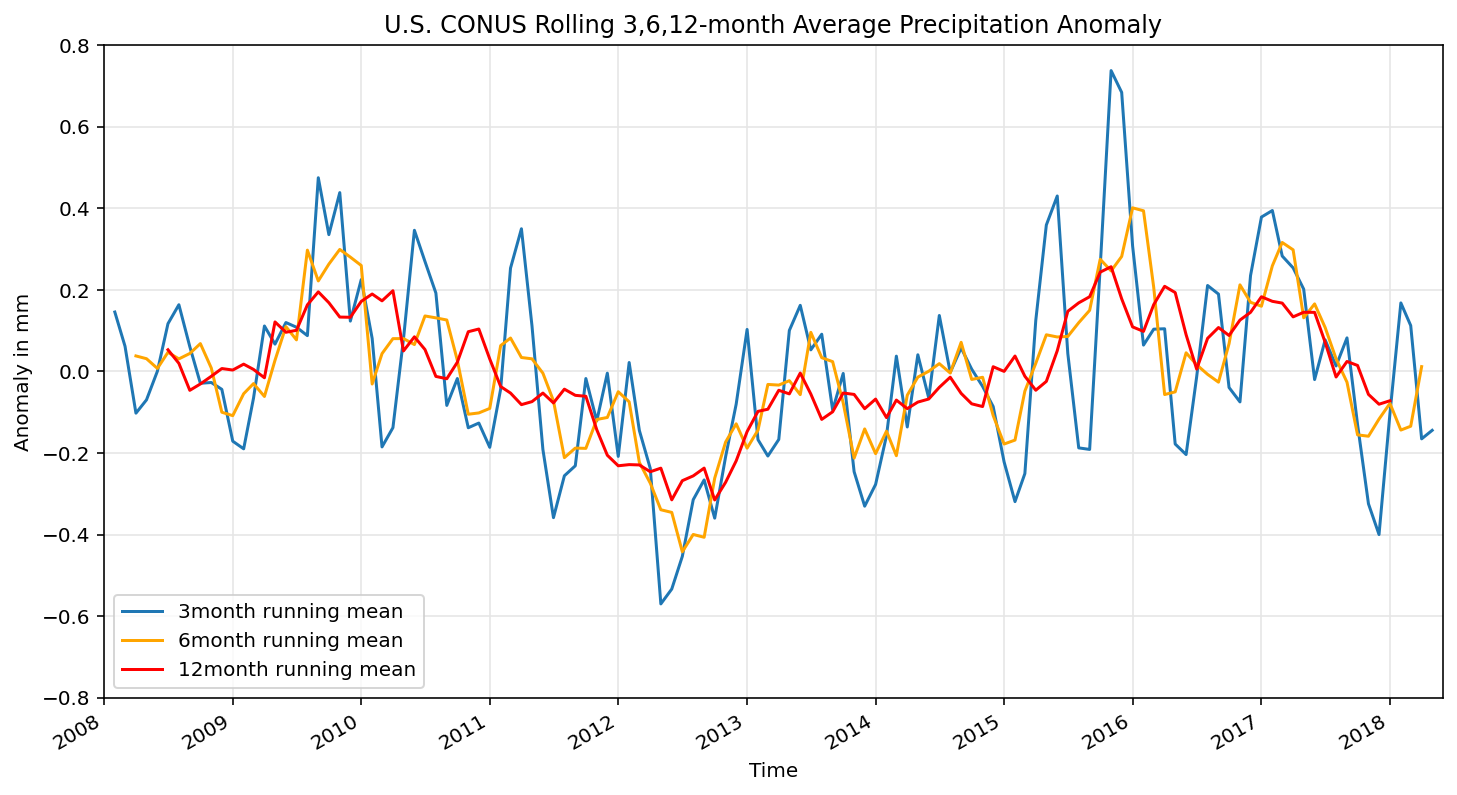

In [4]:
dsp_anom = dsp.groupby('time.month')-dsp.groupby('time.month').mean(dim='time')
rolling_3m= dsp_anom.precip.mean(dim=('lat','lon')).rolling(time=3,center=True).mean()
rolling_6m= dsp_anom.precip.mean(dim=('lat','lon')).rolling(time=6,center=True).mean()
rolling_12m= dsp_anom.precip.mean(dim=('lat','lon')).rolling(time=12,center=True).mean()
rolling_3m.plot(label='3month running mean')
rolling_6m.plot(label='6month running mean',color='orange')
rolling_12m.plot(label='12month running mean',color='red')
plt.xlim(dsp.time[0],dsp.time[-1]);
plt.ylim([-0.8,0.8])
plt.ylabel('Anomaly in mm')
plt.legend(loc='lower left')
plt.grid(color='0.9')
plt.title('U.S. CONUS Rolling 3,6,12-month Average Precipitation Anomaly')

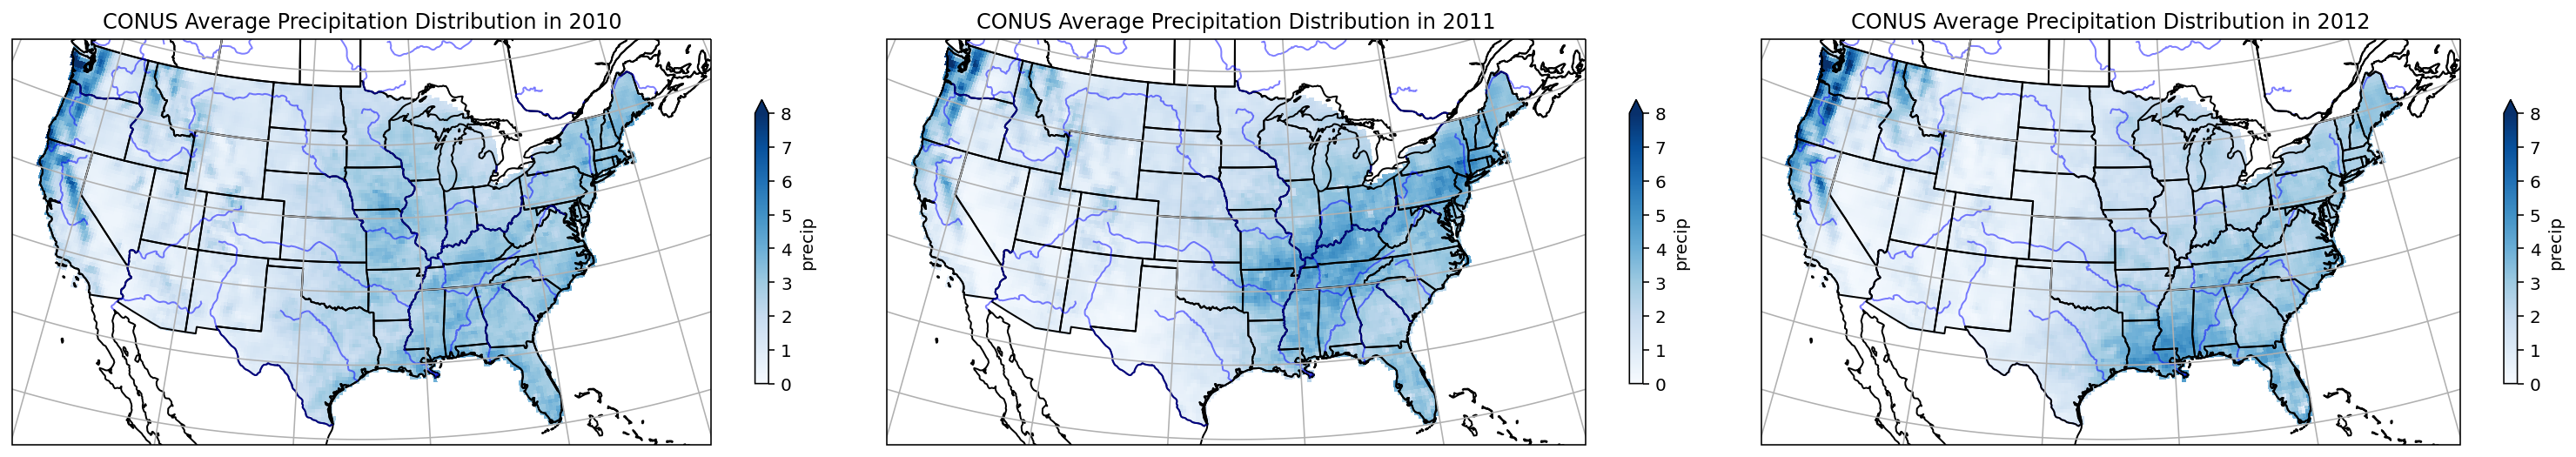

In [5]:
dsp_2012=dsp.sel(time=slice('2012-01-01','2012-12-01')).load()
dsp_2011=dsp.sel(time=slice('2011-01-01','2011-12-01')).load()
dsp_2010=dsp.sel(time=slice('2010-01-01','2010-12-01')).load()

central_lat = 37.5
central_lon = -96
extent = [-120, -70, 22, 50]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')

fig = plt.figure(figsize = (27,10))
ax0 = fig.add_subplot(131,projection=ccrs.LambertConformal(central_lon, central_lat))
ax0.set_extent(extent)
ax0.coastlines()
ax0.gridlines()
ax0.add_feature(cartopy.feature.STATES, edgecolor='black')
dsp_2010.precip.mean(dim='time').plot(ax=ax0,  transform = ccrs.PlateCarree(),cmap='Blues',cbar_kwargs={'shrink': 0.3},vmin=0,vmax=8)
ax0.set_title('CONUS Average Precipitation Distribution in 2010');
ax0.add_feature(rivers_50m, facecolor='None', edgecolor='b',alpha=0.5)

ax1 = fig.add_subplot(132,projection=ccrs.LambertConformal(central_lon, central_lat))
dsp_2011.precip.mean(dim='time').plot(ax=ax1,  transform = ccrs.PlateCarree(),cmap='Blues',cbar_kwargs={'shrink': 0.3},vmin=0,vmax=8)
ax1.set_title('CONUS Average Precipitation Distribution in 2011');
ax1.set_extent(extent)
ax1.coastlines()
ax1.gridlines()
ax1.add_feature(cartopy.feature.STATES, edgecolor='black')
ax1.add_feature(rivers_50m, facecolor='None', edgecolor='b',alpha=0.5)

ax2 = fig.add_subplot(133,projection=ccrs.LambertConformal(central_lon, central_lat))
ax2.set_extent(extent)
ax2.coastlines()
ax2.gridlines()
ax2.add_feature(rivers_50m, facecolor='None', edgecolor='b',alpha=0.5)
ax2.add_feature(cartopy.feature.STATES, edgecolor='black')
dsp_2012.precip.mean(dim='time').plot(ax=ax2,  transform = ccrs.PlateCarree(),cmap='Blues',cbar_kwargs={'shrink': 0.3},vmin=0,vmax=8)
ax2.set_title('CONUS Average Precipitation Distribution in 2012');

fig.subplots_adjust(wspace=0.001, hspace=0)

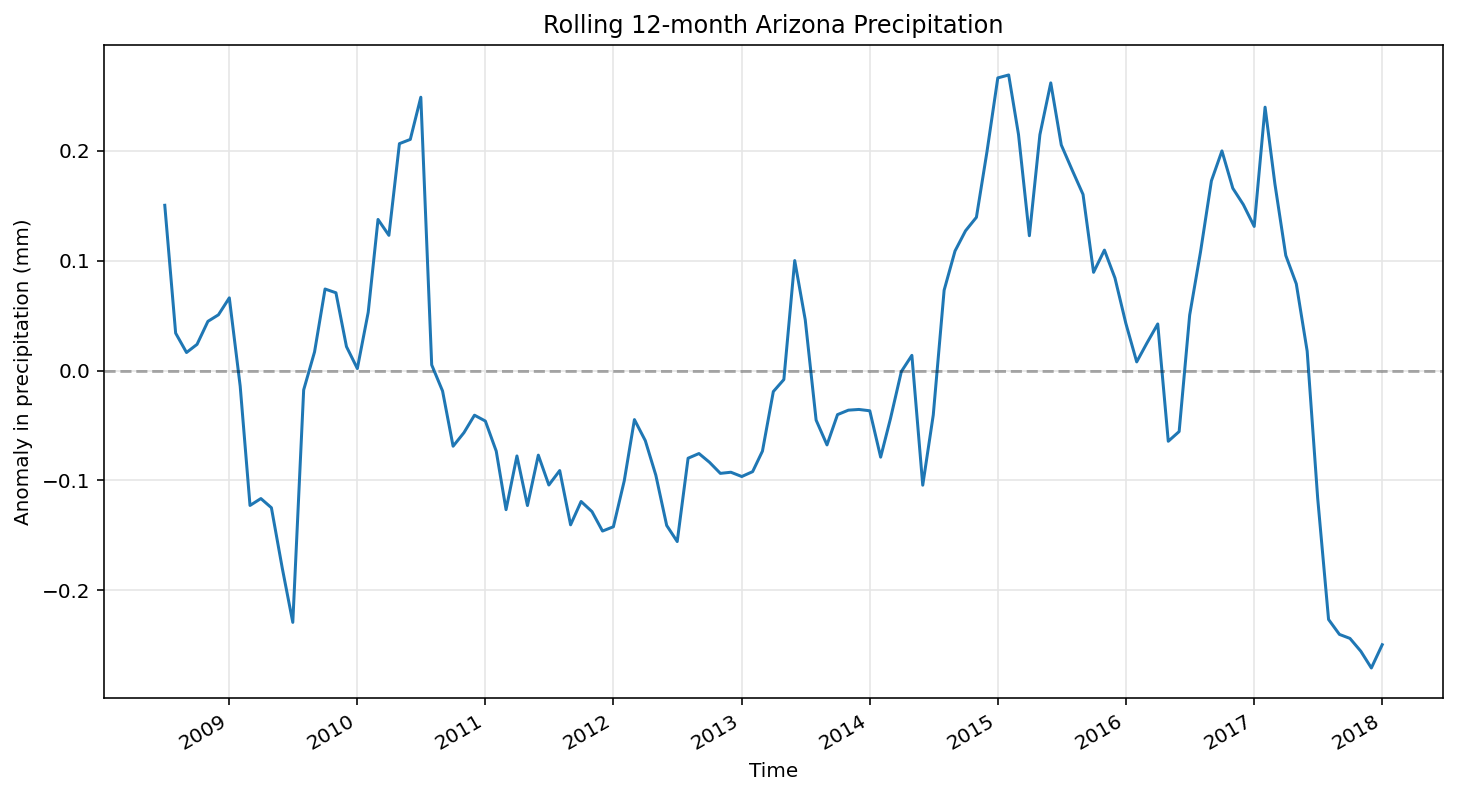

In [6]:
az=dsp.sel(lat=slice(31.36,37),lon=slice(245.45,251)).load()
az_anom = az.groupby('time.month')-az.groupby('time.month').mean(dim='time')
az_anom.precip.mean(dim=('lat','lon')).rolling(time=12,center=True).mean().plot()
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.title('Rolling 12-month Arizona Precipitation')
plt.ylabel('Anomaly in precipitation (mm)');
plt.grid(color='0.9')

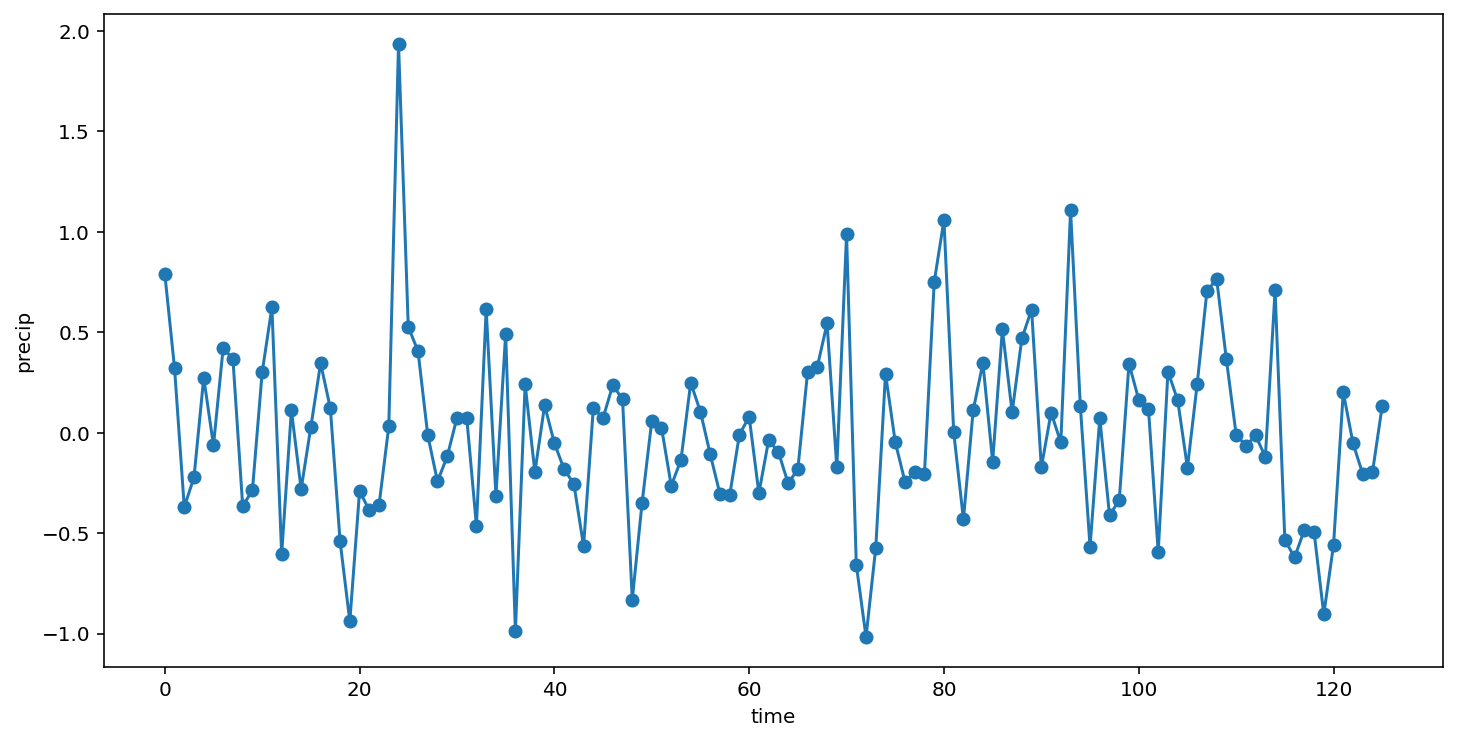

In [122]:
az_p=az_anom.precip.resample(time='M').mean(dim=('lat','lon'))
az_p.plot(marker='o')

In [9]:
# find the indices of the points in (x,y) closest to the points in (xi,yi)
def nearxy(x,y,xi,yi):
    ind = np.ones(len(xi),dtype=int)
    for i in range(len(xi)):
        dist = np.sqrt((x-xi[i])**2+(y-yi[i])**2)
        ind[i] = dist.argmin()
    return ind

In [45]:
lat= np.linspace(36.0115,36.5102, 50 )
lon= np.linspace(-112.0620,-109.7164, 50)

ind = nearxy(ds.longitude,ds.latitude,lon, lat)
print(ind)

[2164722 2164721 2164770 2165100 2164943 2164948 2136243 2136196 2136193
 2136191 2136182 2136178 2136158 2135206 2135161 2135155 2135155 2135149
 2135148 2135148 2135181 2656848 2656848 2135467 2135634 2135633 2135443
 2135636 2135448 2135439 2135427 2135410 2135614 2135395 2135750 2135389
 2135373 2135739 2135813 2135736 2139045 2139165 2139035 2139032  131023
  131010  130993  130859  130857  130988]


In [46]:
dssf= ds.streamflow.sel(feature_id=ds.streamflow[:,ind].feature_id, time=slice('2008-01-01','2018-06-01')).load()

In [134]:
ds

<xarray.Dataset>
Dimensions:         (feature_id: 2729077, time: 227904)
Coordinates:
  * feature_id      (feature_id) int32 101 179 181 ... 1180001803 1180001804
    latitude        (feature_id) float32 dask.array<chunksize=(2729077,), meta=np.ndarray>
    longitude       (feature_id) float32 dask.array<chunksize=(2729077,), meta=np.ndarray>
  * time            (time) datetime64[ns] 1993-01-01 ... 2018-12-31T23:00:00
Data variables:
    elevation       (time, feature_id) float32 dask.array<chunksize=(672, 30000), meta=np.ndarray>
    order           (time, feature_id) int32 dask.array<chunksize=(672, 30000), meta=np.ndarray>
    qBtmVertRunoff  (time, feature_id) float64 dask.array<chunksize=(672, 30000), meta=np.ndarray>
    qBucket         (time, feature_id) float64 dask.array<chunksize=(672, 30000), meta=np.ndarray>
    qSfcLatRunoff   (time, feature_id) float64 dask.array<chunksize=(672, 30000), meta=np.ndarray>
    q_lateral       (time, feature_id) float64 dask.array<chunksize=(672, 30000), meta=np.ndarray>
    streamflow      (time, feature_id) float64 dask.array<chunksize=(672, 30000), meta=np.ndarray>
    velocity        (time, feature_id) float64 dask.array<chunksize=(672, 30000), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.6
    cdm_datatype:               Station
    code_version:               v5.1.0-alpha11
    dev:                        dev_ prefix indicates development/internal me...
    dev_NOAH_TIMESTEP:          3600
    dev_OVRTSWCRT:              1
    dev_channelBucket_only:     0
    dev_channel_only:           0
    featureType:                timeSeries
    model_configuration:        retrospective
    model_initialization_time:  2018-10-01_00:00:00
    model_output_type:          channel_rt
    model_output_valid_time:    2018-12-28_00:00:00
    model_total_valid_times:    2208
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    station_dimension:          feature_id
    stream_order_output:        1

In [13]:
#dssf_anom = dssf.groupby('time.month')-dssf.groupby('time.month').mean(dim='time')
#resam= dssf_anom.resample(time='M').mean() #total flow anomaly each month
#rolling_12m=resam.rolling(time=12,center=True).mean(dim='time').plot() 
#plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
#plt.title('A Section of Salt River 12-month Rolling Average Streamflow')
#plt.ylabel('Anomaly in flow (cfs)');
#plt.grid(color='0.9')

In [113]:
dssf_a=dssf.groupby('time.month')-dssf.groupby('time.month').mean(dim='time')
dssf_b=dssf_a.resample(time='M').mean(dim='time')
dssf_sum=dssf_b.sum(dim='feature_id')
dssf_sum

<xarray.DataArray 'streamflow' (time: 126)>
array([ 155.9517927 ,  228.59889956,  168.76687062,  160.60475904,
         52.25233265,   26.62236241,   16.09156953,    9.80245677,
         -5.90902487,  -13.89911125,  -20.73769954,  -24.22672661,
        -41.14794752,  -59.46892035,  -57.67532862,  -44.16618083,
        -18.672612  ,  -16.25601163,  -10.55472019,  -16.70898081,
        -46.45838507,  -53.31775284,  -54.69543489,  -60.94888977,
        -79.48238214,  -44.01375701,  -22.72308478,   53.62033087,
         23.38695696,    1.98244629,   -4.77646764,   14.93646203,
         32.74816871,   45.05157292,   41.62821574,   15.14038273,
        -22.45292105,  -50.68482829,  -61.09484468,  -40.55245869,
        -16.75383516,  -16.70399773,  -15.24469321,  -20.57277105,
        -25.06205222,   13.79271609,   17.43620239,    8.24272159,
        -29.26001767,  -61.74682671,  -82.7618872 ,  -56.66206944,
        -27.64121395,  -26.56258085,  -22.87488121,  -27.73785153,
        -49.68973222,  -49.92318302,  -51.49728218,  -58.77300272,
        -92.81867217,  -99.56503553,  -84.6350592 ,  -45.95388912,
        -32.72328373,  -30.92371964,  -24.30029784,  -22.1356608 ,
         68.12214014,   46.24154601,   29.69906323,   67.21172565,
         23.62020964,  -37.68622739,  -66.23832574,  -46.97145855,
        -19.67150982,  -19.24678934,  -14.94490827,  -19.01420925,
        -33.21576037,  -19.70455467,   -4.47243601,   -9.75131027,
        -17.19638891,   13.75216432,   99.79214098,   39.31705341,
         38.27402651,   38.76218158,   42.26502325,   59.64143415,
         75.53930664,   72.81235187,   93.11833959,  100.48693996,
         53.53573316,   24.91634665,    4.99114847,  -18.0065703 ,
          7.95295192,   12.0134044 ,   10.28904278,    5.89480901,
         -8.44014981,  -17.8331703 ,  -16.36528297,    9.03727802,
        136.70364797,  200.52635657,  240.29408676,  101.1777187 ,
         55.12641861,   31.90857062,   24.0503328 ,   15.89431147,
         -7.63451094,  -23.2204148 ,  -34.11368535,  -46.41911859,
        -87.45305401, -121.47704397, -138.7157166 , -102.40723508,
        -61.53023201,  -47.87598315])
Coordinates:
  * time     (time) datetime64[ns] 2008-01-31 2008-02-29 ... 2018-06-30

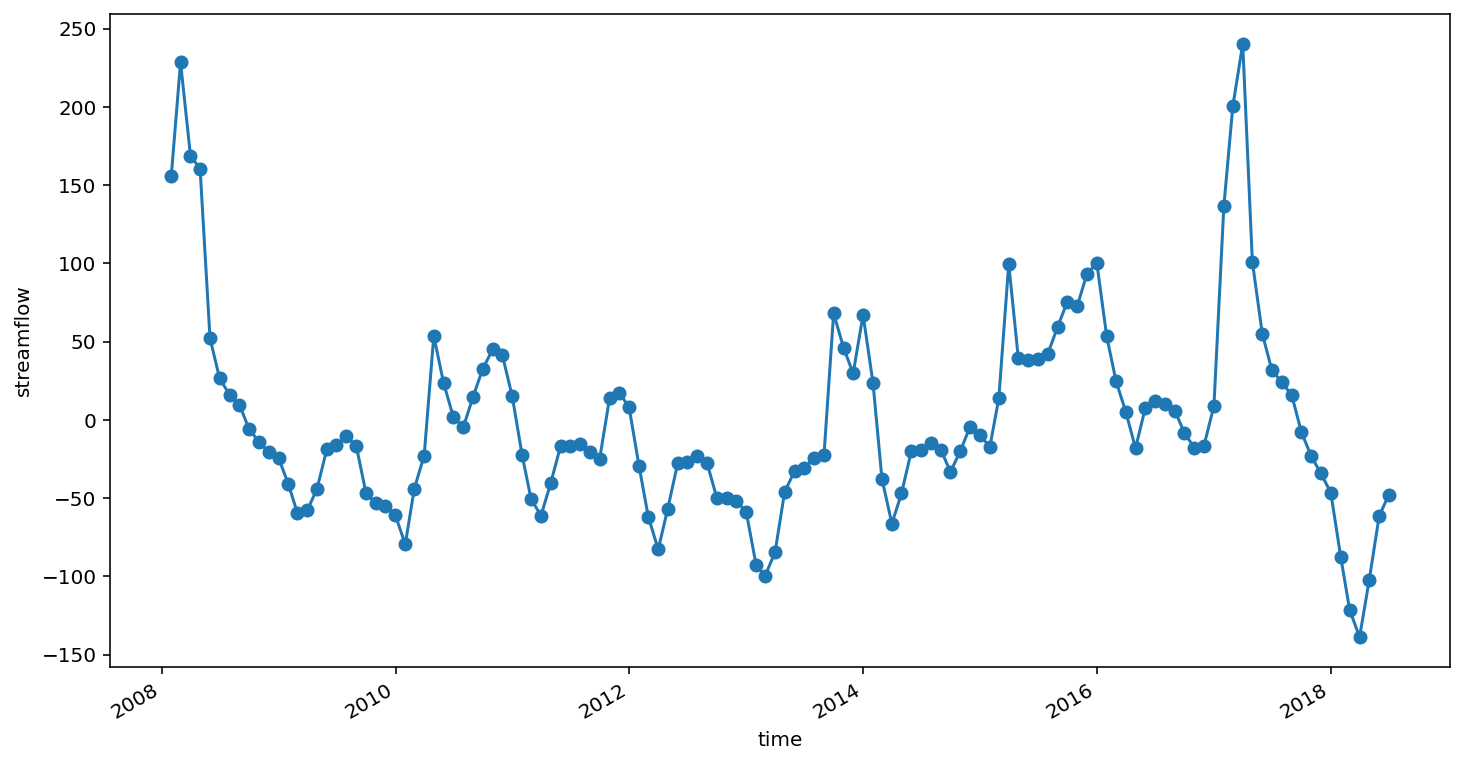

In [116]:
dssf_sum.plot(marker='o')

In [50]:
cr= np.zeros_like(dssf_b.feature_id)
for k in range(len(dssf_b.feature_id)):
    cr[k]=xr.corr(dssf_b.sel(feature_id=dssf_b.feature_id[k]),az_p)
cr

ValueError: different number of dimensions on data and dims: 1 vs 0

In [51]:
dssf_b.assign_coords.zeros_like(dssf_b.feature_id)

AttributeError: 'function' object has no attribute 'zeros_like'

Compare Selected location's precipitation and streamflow

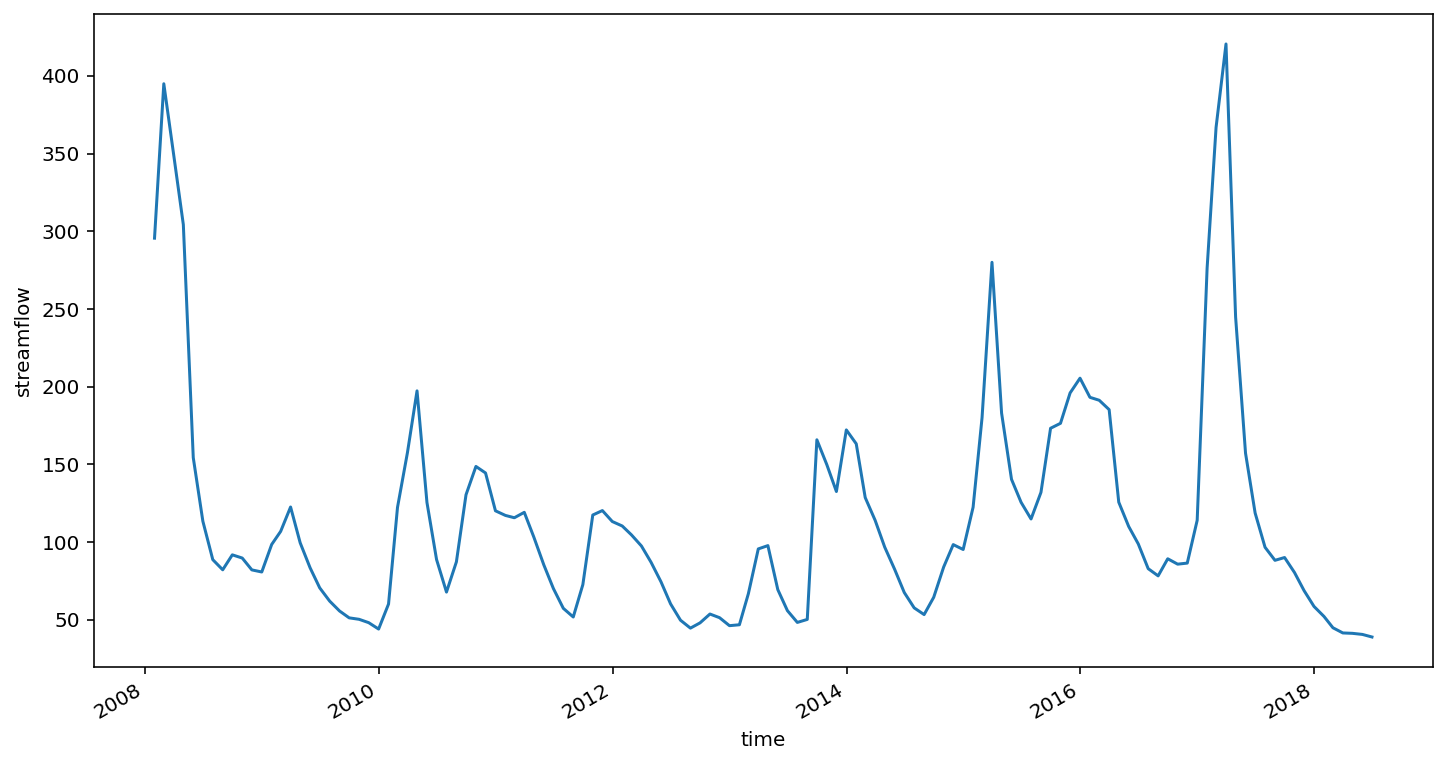

In [53]:
dssf_mo= dssf.resample(time='M').mean()
dssf_sum=dssf_mo.sum(dim='feature_id')
dssf_sum.plot()

In [127]:
np.correlate(az_p,dssf_sum)

array([539.95346798])

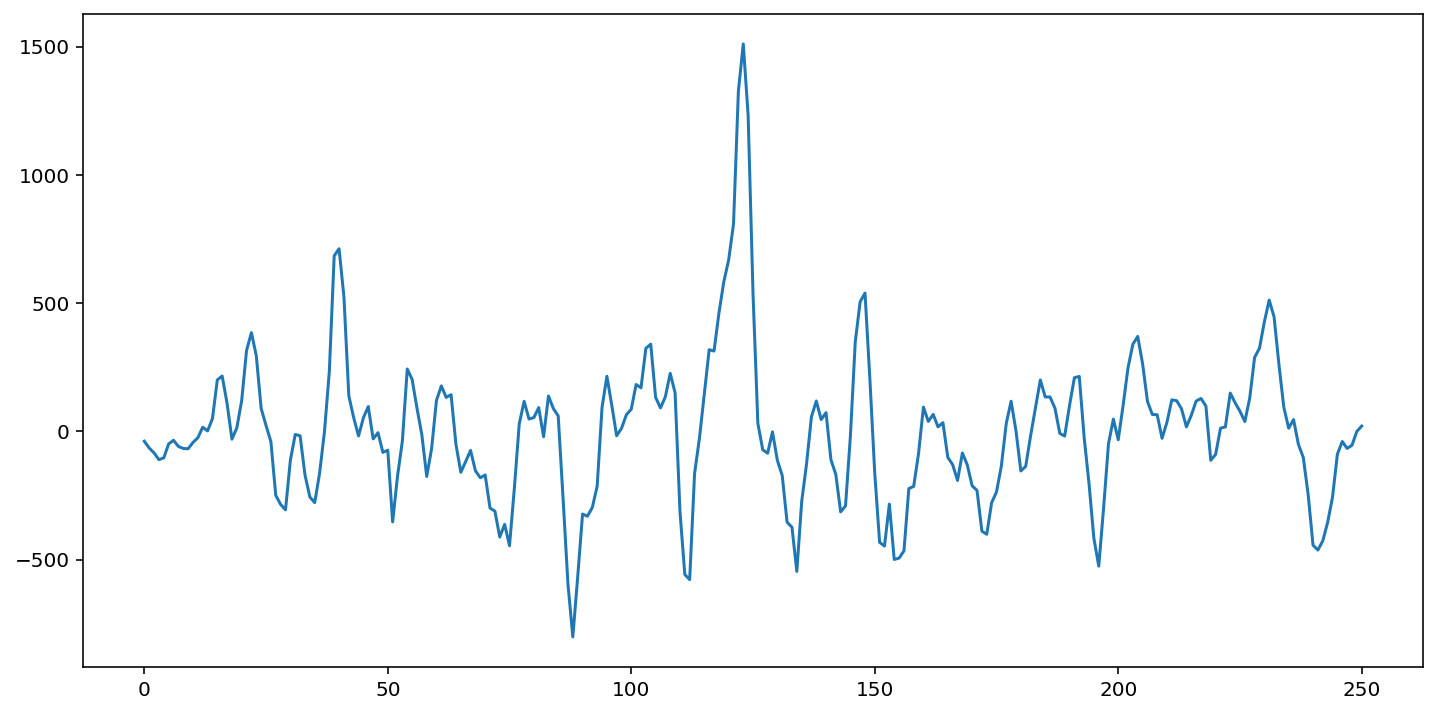

In [132]:
from scipy import signal
corr=signal.correlate(az_p,dssf_sum)
plt.plot(corr)

In [133]:
az_p

<xarray.DataArray 'precip' (time: 126)>
array([ 0.7925332 ,  0.32433784, -0.36885744, -0.22142148,  0.27510908,
       -0.06234234,  0.42479044,  0.3658105 , -0.36469606, -0.28518322,
        0.3010369 ,  0.6246161 , -0.6037879 ,  0.11274515, -0.28001055,
        0.02993169,  0.3465937 ,  0.12263267, -0.5389615 , -0.9375509 ,
       -0.28942347, -0.38542902, -0.35898066,  0.03258444,  1.9351804 ,
        0.52748704,  0.4071579 , -0.01116752, -0.24124971, -0.11708737,
        0.07543965,  0.07643624, -0.4626766 ,  0.6157046 , -0.31272578,
        0.4934052 , -0.9880765 ,  0.24193543, -0.1956499 ,  0.13709705,
       -0.05061805, -0.18110237, -0.2528558 , -0.5629885 ,  0.12389949,
        0.07397768,  0.23785932,  0.16701527, -0.83010244, -0.35080215,
        0.05926362,  0.02668355, -0.26314694, -0.13402398,  0.24919575,
        0.10511578, -0.10570069, -0.3033554 , -0.31140712, -0.00851331,
        0.07997081, -0.29965374, -0.03635642, -0.09439512, -0.25073954,
       -0.18076114,  0.30244222,  0.32944766,  0.54437476, -0.17182438,
        0.98809713, -0.6557613 , -1.0152981 , -0.5705823 ,  0.2943938 ,
       -0.04566243, -0.24301134, -0.19532946, -0.20390026,  0.7502833 ,
        1.0586272 ,  0.0047033 , -0.42982626,  0.11140753,  0.34762314,
       -0.14299515,  0.5152032 ,  0.10186436,  0.4702217 ,  0.6136499 ,
       -0.17189519,  0.10057803, -0.04724257,  1.1080052 ,  0.13608338,
       -0.5667842 ,  0.07401903, -0.40981123, -0.33502313,  0.34457996,
        0.16528018,  0.11904089, -0.5933517 ,  0.30520308,  0.16225399,
       -0.17314707,  0.24235472,  0.70472294,  0.7656917 ,  0.36518136,
       -0.00818482, -0.06356554, -0.01285655, -0.11950422,  0.70909655,
       -0.5323351 , -0.619416  , -0.4834517 , -0.49249154, -0.9026925 ,
       -0.55775356,  0.20215765, -0.05193625, -0.20394452, -0.19558246,
        0.13482744], dtype=float32)
Coordinates:
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 8 9 10 11 12 1 2 3 4 5 6
Dimensions without coordinates: time